In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from PIL import Image
import torch.nn.functional as F
from torchmetrics.image import StructuralSimilarityIndexMeasure

c:\Users\nguye\Documents\Github\AI-Tool-for-Room-Decoration1\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_dir = 'img'

In [3]:
def normalize_and_scale(image, new_min=0, new_max=1):
    image = image.astype(np.float32)
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

In [4]:
def calculate_cosine_score(original_image, modified_image):
    original_tensor = torch.tensor(original_image, dtype=torch.float32)
    modified_tensor = torch.tensor(modified_image, dtype=torch.float32)

    original_vector = original_tensor.flatten()
    modified_vector = modified_tensor.flatten()

    max_size = max(original_vector.size(0), modified_vector.size(0))
    original_vector = F.pad(original_vector, (0, max_size - original_vector.size(0)), mode='constant', value=0)
    modified_vector = F.pad(modified_vector, (0, max_size - modified_vector.size(0)), mode='constant', value=0)

    cosine_similarity = F.cosine_similarity(original_vector.unsqueeze(0), modified_vector.unsqueeze(0), dim=1)

    return cosine_similarity.item()

In [5]:
from skimage.metrics import structural_similarity as ssim
from skimage.color import rgb2gray
from skimage.transform import resize

def calculate_ssim_score(original_image, modified_image):
    # Remove alpha channel if present
    original_image = original_image[:, :, :3]
    modified_image = modified_image[:, :, :3]
    
    # Convert images to grayscale
    original_gray = rgb2gray(original_image)
    modified_gray = rgb2gray(modified_image)

    if original_gray.shape != modified_gray.shape:
        modified_gray = resize(modified_gray, original_gray.shape, anti_aliasing=True)
    
    # Calculate SSIM
    ssim_score, _ = ssim(original_gray, modified_gray, full=True, data_range=1.0)
    
    return ssim_score

In [6]:
from skimage.metrics import peak_signal_noise_ratio
from skimage.transform import resize

def calculate_psnr(original_image, modified_image, data_range=255):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

    Parameters:
        original_image (numpy.ndarray): The original image.
        modified_image (numpy.ndarray): The modified image.
        data_range (float): The range of the pixel values (default is 255 for uint8 images).

    Returns:
        float: The PSNR value.
    """
    if original_image.shape != modified_image.shape:
        modified_image = resize(modified_image, original_image.shape, anti_aliasing=True)
    
    return peak_signal_noise_ratio(
        original_image, modified_image, data_range=data_range
    )


In [7]:
# Set the base directory
base_dir = 'img'

# Get the list of image files in the 'original' folder
original_folder = os.path.join(base_dir, 'Original')
original_files = os.listdir(original_folder)

file_names = []
cosine_scores = []
ssim_scores = []
psnr_scores= []

for original_file in original_files:
    # Construct the full file paths
    original_path = os.path.join(original_folder, original_file)
    modified_path = os.path.join(os.path.join(base_dir, 'OurModel'), original_file)

    # Load the images
    original_image = np.array(Image.open(original_path))
    modified_image = np.array(Image.open(modified_path))
    
    # Resize the smaller image to match the larger one
    original_size = original_image.shape[:2]
    modified_size = modified_image.shape[:2]
    if original_size != modified_size:
        if original_size[0] > modified_size[0] or original_size[1] > modified_size[1]:
            modified_image = np.array(Image.fromarray(modified_image).resize(original_size, resample=Image.BICUBIC))
        else:
            original_image = np.array(Image.fromarray(original_image).resize(modified_size, resample=Image.BICUBIC))

    # Calculate the cosine similarity score
    cosine_score = calculate_cosine_score(original_image, modified_image)
    cosine_scores.append(cosine_score)

    #Calculate SSIM
    ssim_score = calculate_ssim_score(original_image, modified_image)
    ssim_scores.append(ssim_score)
    
    psnr_score = calculate_psnr(original_image, modified_image)
    psnr_scores.append(psnr_score)
    
    # Calculate the SSIM score
    file_names.append(original_file)
    
    print(f"File: {original_file}, Cosine Similarity: {cosine_score}, SSIM: {ssim_score}, PSNR: {psnr_score}")


File: 1.png, Cosine Similarity: 0.9167265892028809, SSIM: 0.8013331668952776, PSNR: 4.094473729017246
File: 2.png, Cosine Similarity: 0.8870594501495361, SSIM: 0.8719600692174151, PSNR: 3.9994478481852616
File: 3.png, Cosine Similarity: 0.9015082120895386, SSIM: 0.6870916812156016, PSNR: 3.8699370835011626
File: 4.png, Cosine Similarity: 0.8634884357452393, SSIM: 0.4765654489963238, PSNR: 5.653826500636602


In [8]:
with open('image_similarity_scores.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['File', 'Cosine Similarity', 'SSIM', 'PSNR'])
    for i in range(len(file_names)):
        writer.writerow([file_names[i], cosine_scores[i], ssim_scores[i], psnr_scores[i]])

In [9]:
def custom_sort(file_name):
    name, ext = os.path.splitext(file_name)
    numeric_part = int(name.split('.')[0])
    return (numeric_part, file_name)

sorted_file_names = sorted(file_names, key=custom_sort)
sorted_cosine_scores = [cosine_scores[file_names.index(file_name)] for file_name in sorted_file_names]
sorted_ssim_scores = [ssim_scores[file_names.index(file_name)] for file_name in sorted_file_names]
sorted_psnr_scores = [psnr_scores[file_names.index(file_name)] for file_name in sorted_file_names]

print(sorted_file_names)

['1.png', '2.png', '3.png', '4.png']


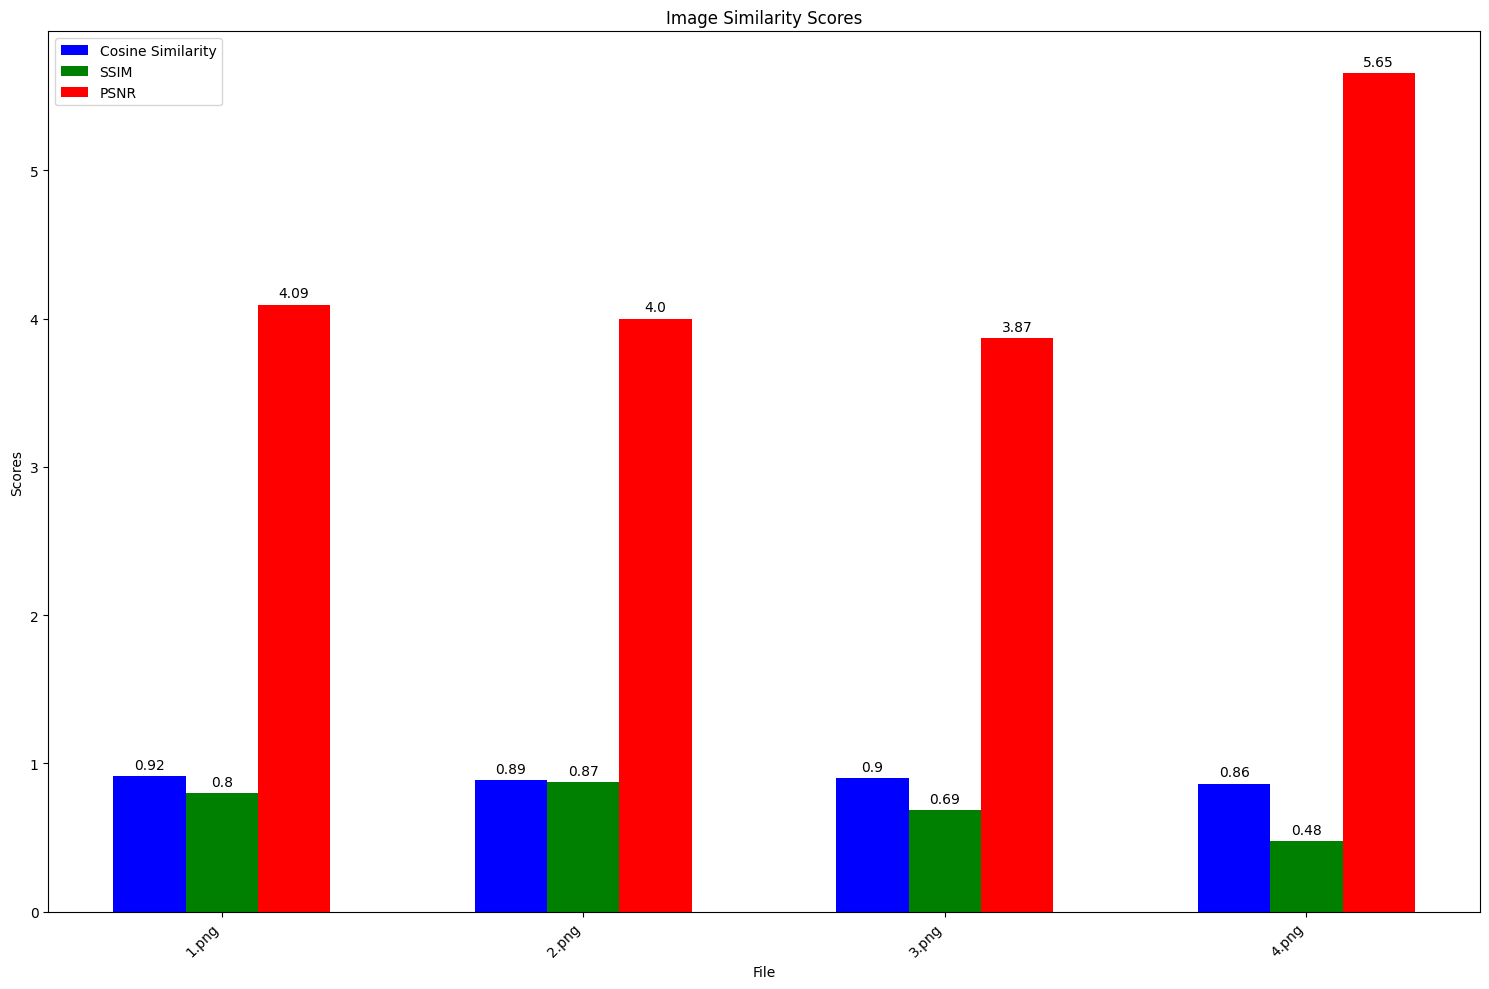

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{round(height, 2)}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
        )
        
bar1 = ax.bar(np.arange(len(sorted_file_names)) - 0.2, sorted_cosine_scores, width=0.2, color='b', label='Cosine Similarity')
bar2 = ax.bar(np.arange(len(sorted_file_names)) + 0.0, sorted_ssim_scores, width=0.2, color='g', label='SSIM')
bar3 = ax.bar(np.arange(len(sorted_file_names)) + 0.2, sorted_psnr_scores, width=0.2, color='r', label='PSNR')

ax.set_xlabel('File')
ax.set_ylabel('Scores')
ax.set_xticks(np.arange(len(sorted_file_names)))
ax.set_xticklabels(sorted_file_names, rotation=45, ha='right')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fancybox=True, shadow=True)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

ax.legend()
plt.title('Image Similarity Scores')
plt.tight_layout()
plt.savefig('image_similarity_plot.png')
plt.show()


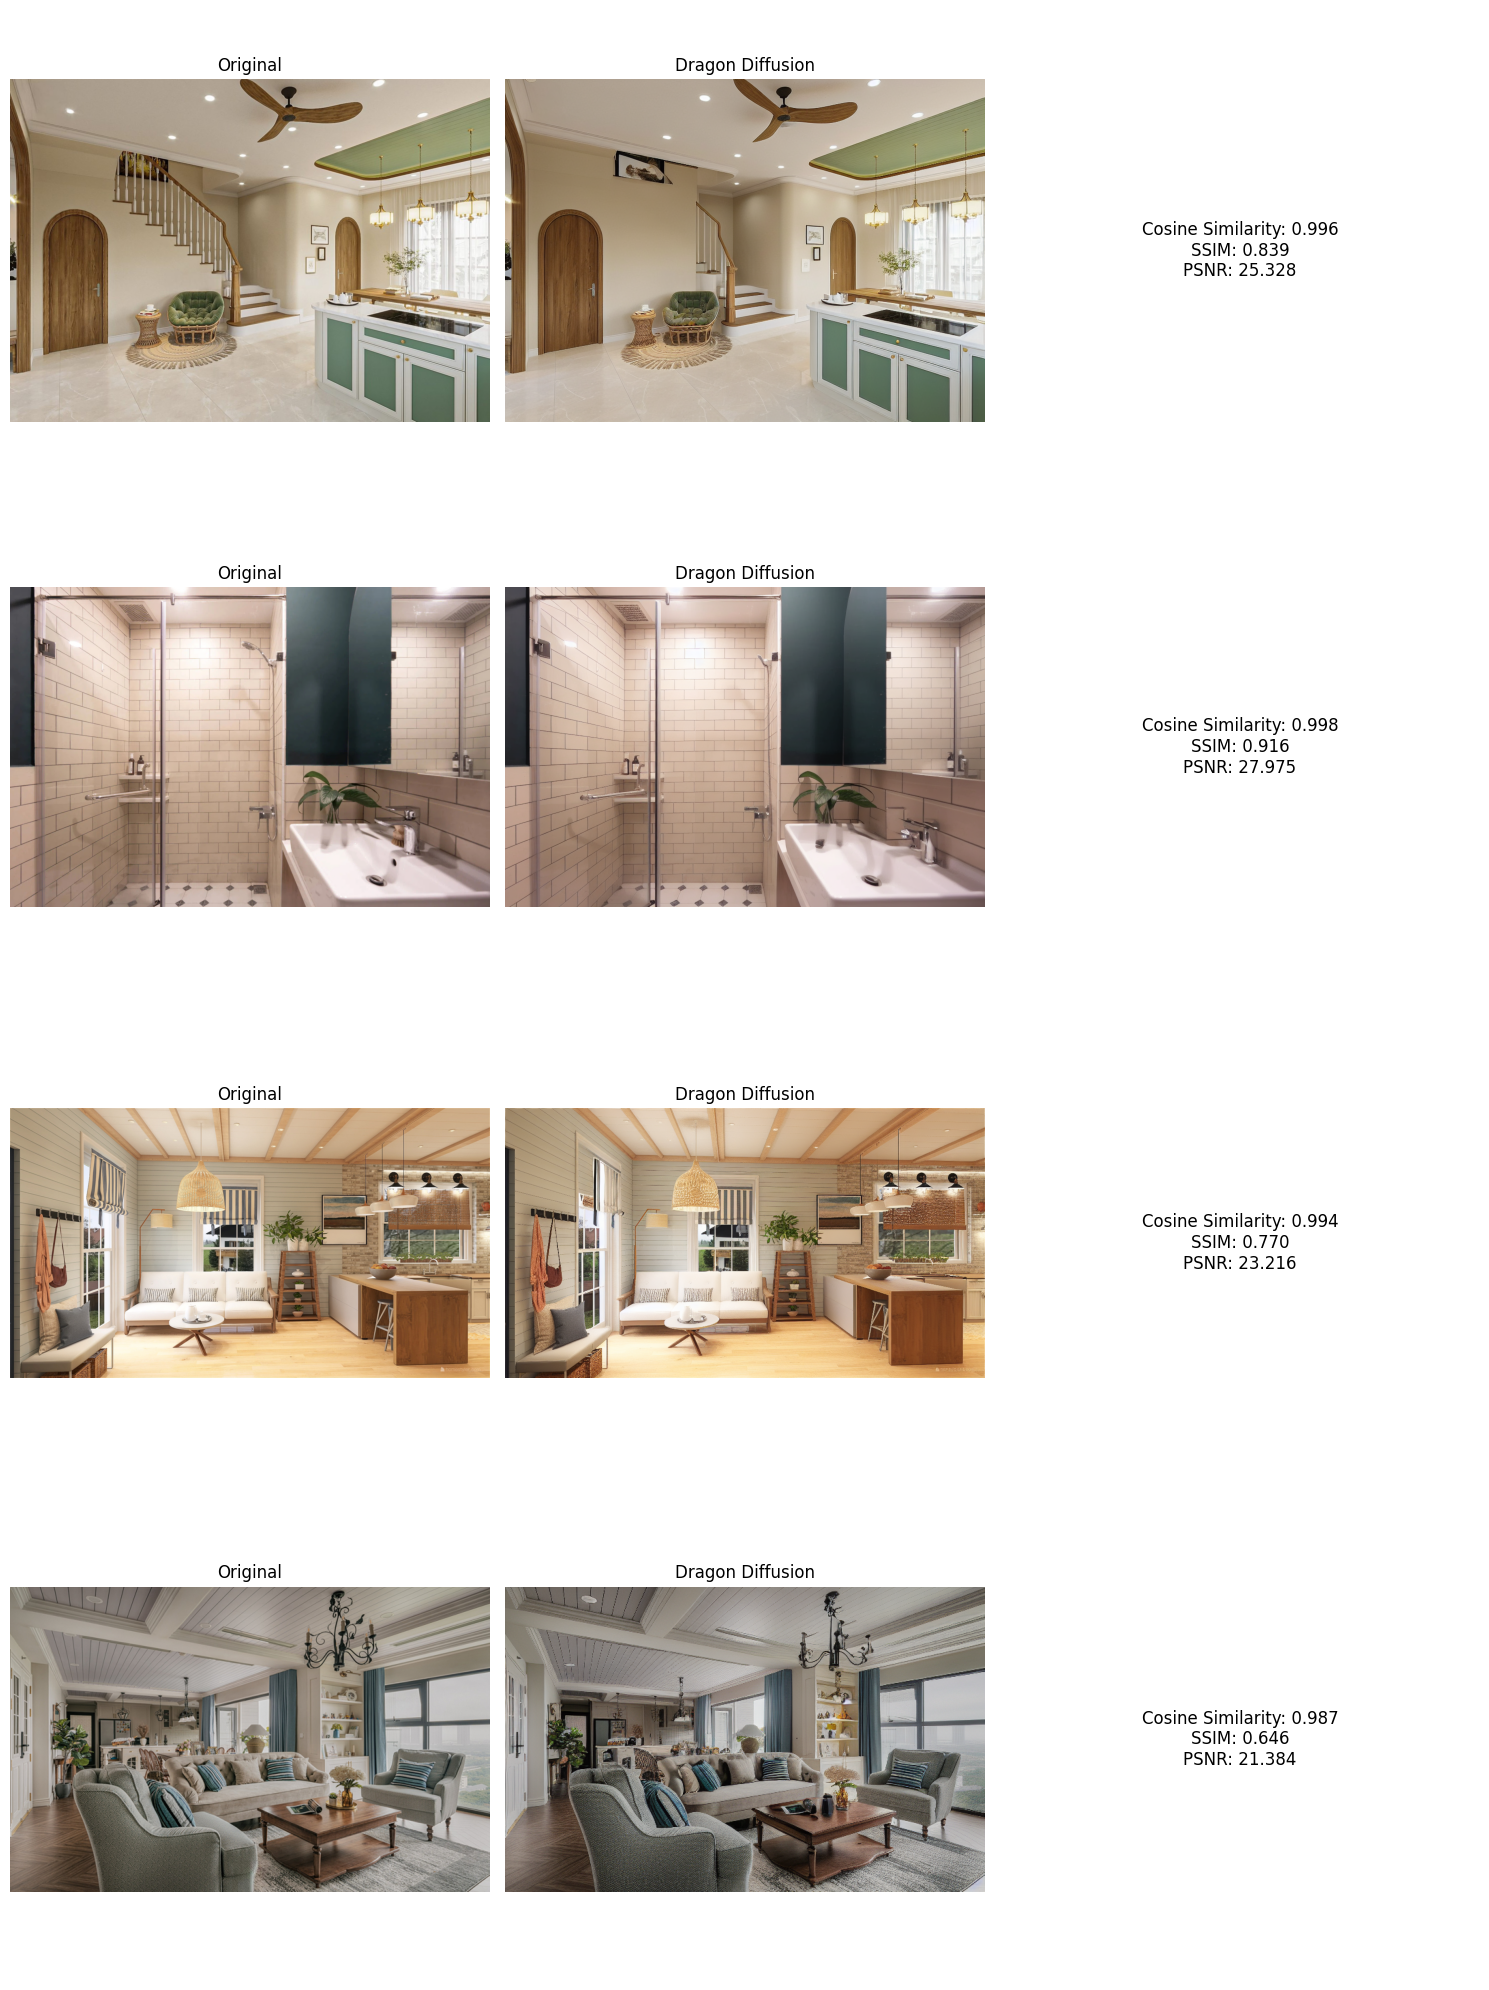

In [11]:
base_dir = 'img'
original_folder = os.path.join(base_dir, 'Original')
modified_folder = os.path.join(base_dir, 'DragonDiffusion')

# Plot the images and their similarity scores
fig, axs = plt.subplots(len(sorted_file_names), 3, figsize=(15, 5*len(sorted_file_names)))

for i, file_name in enumerate(sorted_file_names):
    # Load the original and modified images
    original_image = np.array(Image.open(os.path.join(original_folder, file_name)))
    modified_image = np.array(Image.open(os.path.join(modified_folder, file_name)))

    # Resize the original image to match the dimensions of the modified image
    original_image_resized = np.array(Image.fromarray(original_image).resize(modified_image.shape[:2][::-1]))

    # Calculate the similarity scores
    cosine_similarity = calculate_cosine_score(original_image_resized, modified_image)
    ssim_score = calculate_ssim_score(original_image_resized, modified_image)
    psnr_score = calculate_psnr(original_image_resized, modified_image)

    # Plot the original image
    axs[i, 0].imshow(original_image_resized)
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    # Plot the modified image
    axs[i, 1].imshow(modified_image)
    axs[i, 1].set_title('Dragon Diffusion')
    axs[i, 1].axis('off')

    # Display similarity scores
    axs[i, 2].text(0.5, 0.5, f"Cosine Similarity: {cosine_similarity:.3f}\nSSIM: {ssim_score:.3f}\nPSNR: {psnr_score:.3f}", horizontalalignment='center', verticalalignment='center', fontsize=12)
    axs[i, 2].axis('off')

plt.tight_layout()
plt.savefig('comparison.png')
plt.show()
